### Import Statements

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image
from matplotlib import cm
import seaborn as sns
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
import mlflow
from mlflow.keras import log_model
import mlflow.sklearn
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Input, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import model_selection, preprocessing
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import RFE, chi2, SelectKBest
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, accuracy_score, classification_report, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

#for text processing
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")

### Load Data

In [116]:
df = pd.read_csv("netflix_titles.csv")
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [4]:
df.shape

(8807, 12)

In [5]:
print("No. of directors: ", df[['director']].nunique())
df[['director']].value_counts()

No. of directors:  director    4528
dtype: int64


director                             
Rajiv Chilaka                            19
Raúl Campos, Jan Suter                   18
Suhas Kadav                              16
Marcus Raboy                             16
Jay Karas                                14
                                         ..
Jos Humphrey                              1
Jose Gomez                                1
Jose Javier Reyes                         1
Joseduardo Giordano, Sergio Goyri Jr.     1
Khaled Youssef                            1
Length: 4528, dtype: int64

In [6]:
print("No. of types: ", df[['type']].nunique())
df[['type']].value_counts()

No. of types:  type    2
dtype: int64


type   
Movie      6131
TV Show    2676
dtype: int64

In [7]:
print("No. of ratings: ", df[['rating']].nunique())
df[['rating']].value_counts()

No. of ratings:  rating    17
dtype: int64


rating  
TV-MA       3207
TV-14       2160
TV-PG        863
R            799
PG-13        490
TV-Y7        334
TV-Y         307
PG           287
TV-G         220
NR            80
G             41
TV-Y7-FV       6
UR             3
NC-17          3
74 min         1
84 min         1
66 min         1
dtype: int64

### Clean/Prep Data

In [8]:
df.info()
# TO DO: certain categorical features need be encoded as numerical

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [10]:
df.isnull().sum() 
# TO DO: Null values need to be filled or eliminated

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

In [11]:
#EDITED 5/23/22 NSH

from string import digits
for i in df.index:
    value = (df.loc[i, 'duration'])
    if not pd.isna(value):
        #print(value)
        df.loc[i, 'duration_digit'] = "".join(c for c in value if c in digits)
        #print(df.loc[i, 'duration_digit'])


In [12]:
# Remove null values for columns that have only a few missing values)
df.dropna(axis=0, subset=['date_added', 'rating', 'duration'], inplace=True)

In [13]:
#Replace NaN description values with mode for country column (most likely response)
df['country'] = df['country'].fillna("United States")

In [14]:
# Replace NaN description values with Unknown for director and cast
# Will need to get model to ignore this type if rec engine for director is created
df['director'] = df['director'].fillna("Unknown")
df['cast'] = df['cast'].fillna("Unknown")

In [15]:
# recheck null values
df.isnull().sum() 

show_id           0
type              0
title             0
director          0
cast              0
country           0
date_added        0
release_year      0
rating            0
duration          0
listed_in         0
description       0
duration_digit    0
dtype: int64

### Exploratory Data Analysis (to be completed by Kristy)

In [16]:
df.nunique().sort_values()

type                 2
rating              14
release_year        74
duration_digit     210
duration           220
listed_in          513
country            748
date_added        1765
director          4527
cast              7679
description       8758
show_id           8790
title             8790
dtype: int64

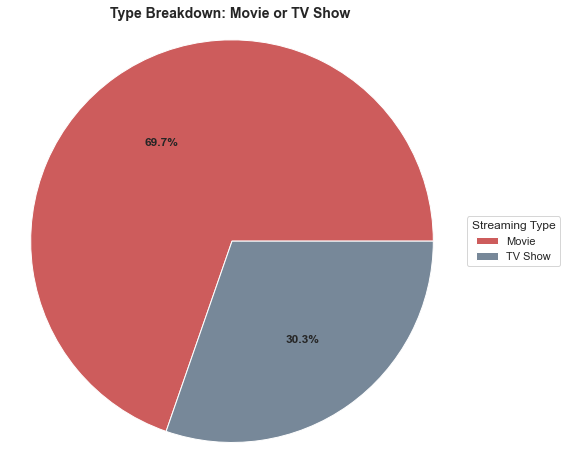

In [27]:
# Pie Chart -  Frequency of Movies vs. TV Shows
type_data = df["type"].value_counts()
type_data_labels = df["type"].value_counts().index.tolist()
colors = ['indianred', 'lightslategray']

plt.figure(figsize=(8,8))
plt.pie(type_data, autopct='%1.1f%%', colors=colors, textprops={'fontweight':'bold'})
plt.title("Type Breakdown: Movie or TV Show", size=14, fontweight="bold")
plt.legend(title='Streaming Type', labels=type_data_labels, loc="right", bbox_to_anchor=(1.25, 0.50))
plt.axis('equal')
plt.show()

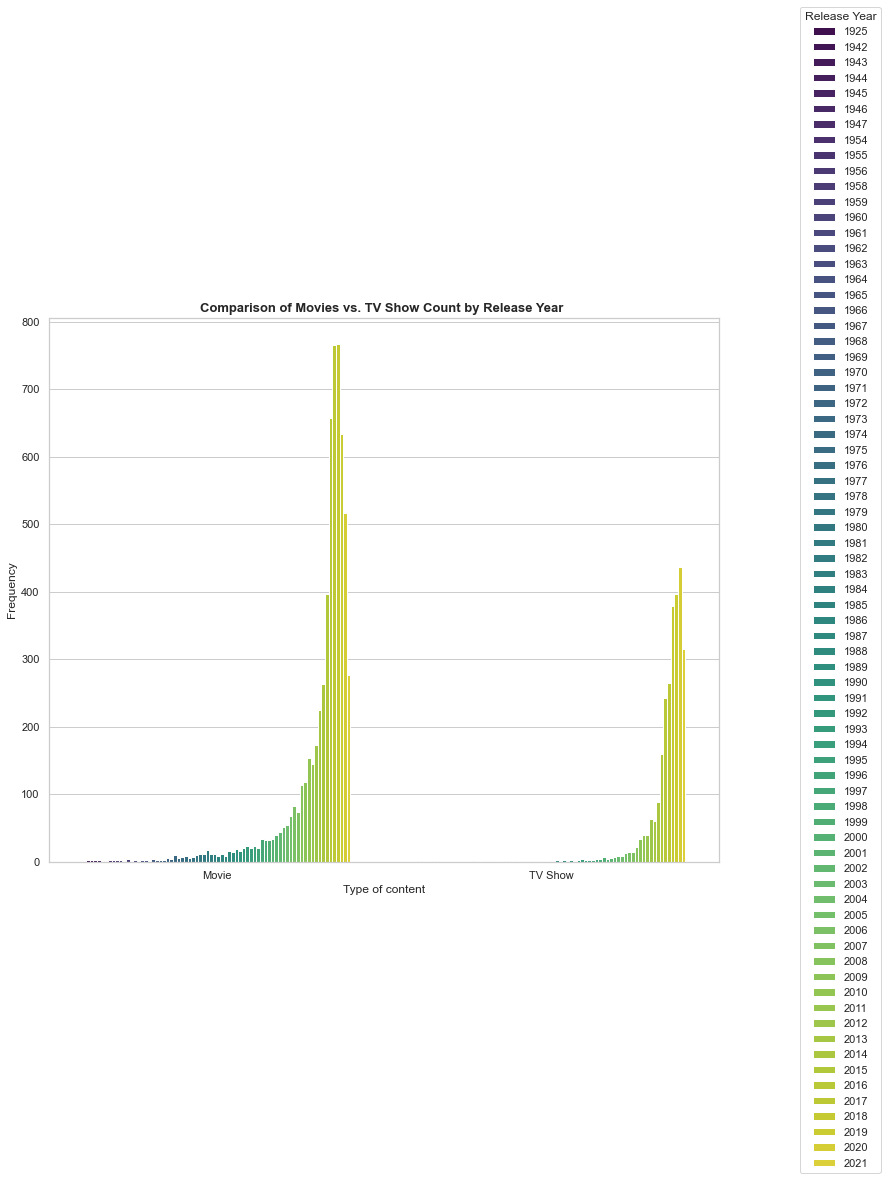

In [39]:
# Histogram - Frequency of Movies vs. TV Shows by Release Year
# Has there been an increase or decrease by type over the years?
sns.set(style="whitegrid")
plt.figure(figsize=(12,10))
sns.countplot(x="type", data=df, hue= 'release_year', palette="viridis")
plt.title ("Comparison of Movies vs. TV Show Count by Release Year ", fontsize=13, fontweight="bold")
plt.xlabel("Type of content", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend(title='Release Year', loc="right", bbox_to_anchor=(1.25, 0.50))

Observation: There is definitely an increase in content as time passes, however the general curve in the frequency count increase seems very similar compariing movies and tv shows, even though movies are more numerous overall.

In [18]:
# Examine rating categories
df.rating.unique()

array(['PG-13', 'TV-MA', 'PG', 'TV-14', 'TV-PG', 'TV-Y', 'TV-Y7', 'R',
       'TV-G', 'G', 'NC-17', 'NR', 'TV-Y7-FV', 'UR'], dtype=object)

Text(0, 0.5, 'Frequency')

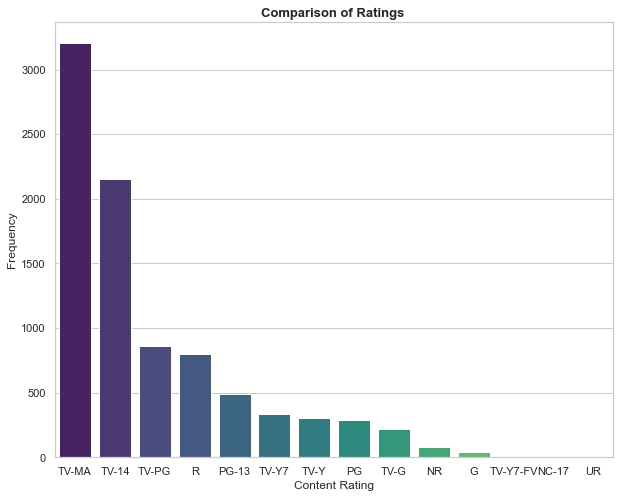

In [41]:
# Histogram - Frequency of Ratings
plt.figure(figsize=(10,8))
sns.countplot(x="rating", data=df, palette="viridis", order=df['rating'].value_counts().index[0:15])
plt.title ("Comparison of Ratings ", fontsize=13, fontweight="bold")
plt.xlabel("Content Rating", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

Observation: The makeup of content skews towards adults and mature teenagers.

In [47]:
# Select top 50 genres by frequency and create new dataframe
top_listed = df['listed_in'].value_counts().index.tolist()[:50]

result_df = df[df['listed_in'].isin(top_listed)] 
#result_df['listed_in'].value_counts()

Text(0, 0.5, 'Frequency')

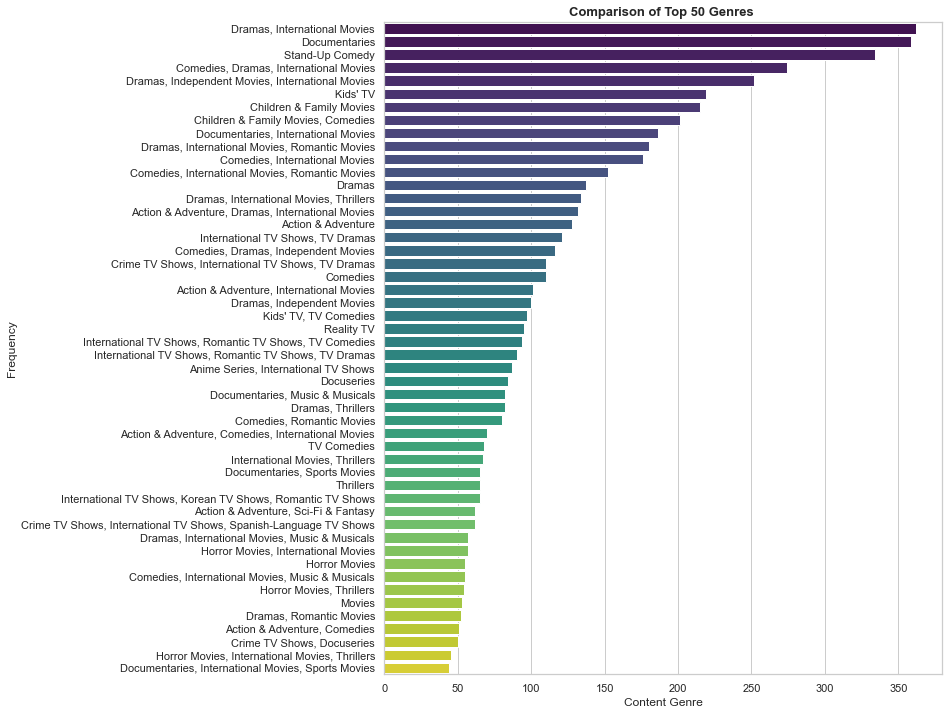

In [46]:
# Histogram - Frequency of Genres 
plt.figure(figsize=(10,12))
sns.countplot(y="listed_in", data=result_df, orient='h', palette="viridis", order=result_df['listed_in'].value_counts().index[0:50])
plt.title ("Comparison of Top 50 Genres ", fontsize=13, fontweight="bold")
plt.xlabel("Content Genre", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

In [50]:
# Split into two dataframes - movies & tv shows
tv_shows=df[df['type']=='TV Show']
movies=df[df['type']=='Movie']

Text(0, 0.5, 'Frequency')

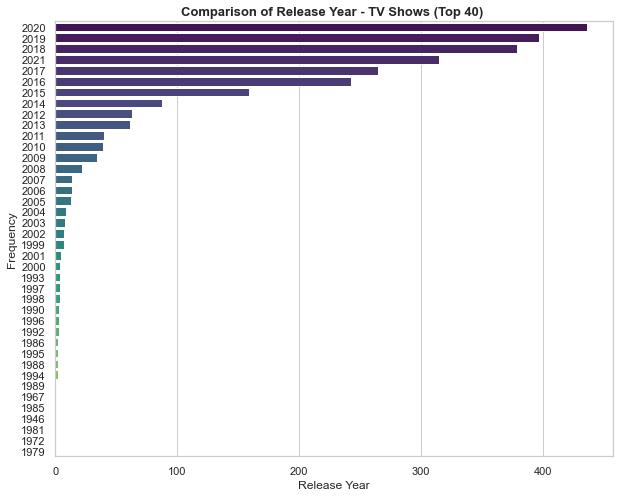

In [60]:
# Histogram - Frequency of Release Year by Country -- TV Shows
plt.figure(figsize=(10,8))
sns.countplot(y="release_year", data=tv_shows,  orient='h', palette="viridis", order=tv_shows['release_year'].value_counts().index[0:40])
plt.title ("Comparison of Release Year - TV Shows (Top 40) ", fontsize=13, fontweight="bold")
plt.xlabel("Release Year", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

Observation: More TV shows were released from 2018-2020 than 2021, most likely because the data for 2021 is not complete.

Text(0, 0.5, 'Frequency')

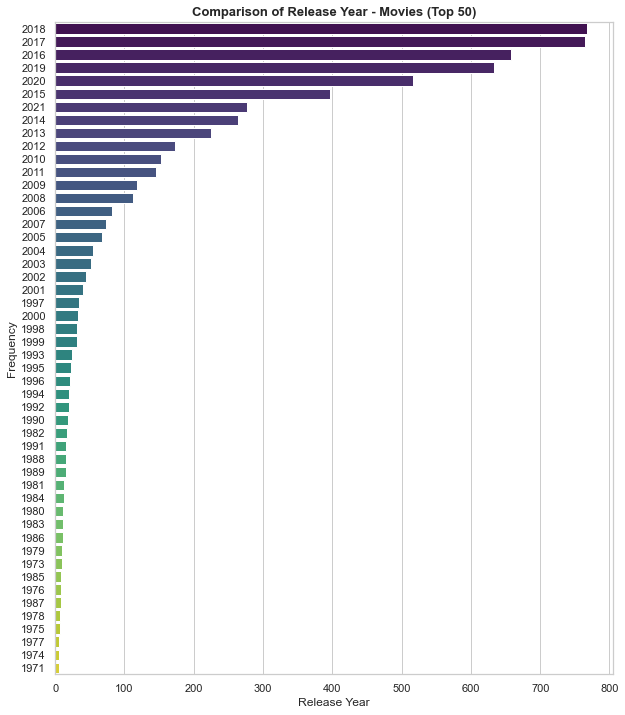

In [59]:
# Histogram - Frequency of Release Year by Country -- Movies
plt.figure(figsize=(10,12))
sns.countplot(y="release_year", data=movies, orient='h', palette="viridis", order=movies['release_year'].value_counts().index[0:50])
plt.title ("Comparison of Release Year - Movies (Top 50)", fontsize=13, fontweight="bold")
plt.xlabel("Release Year", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

Observation: More movies were released from 2016-2020 than 2021, most likely because the data for 2021 is not complete. However clearly less movies were produced in 2020 than prior years-- no doubt due to the global pandemic and filming shut downs.

In [61]:
# Select top 20 countries of origin by frequency and create new dataframe
top_country = df['country'].value_counts().index.tolist()[:20]

rslt_df = df[df['country'].isin(top_country)] 
rslt_df['country'].value_counts()

United States                    3638
India                             972
United Kingdom                    418
Japan                             243
South Korea                       199
Canada                            181
Spain                             145
France                            124
Mexico                            110
Egypt                             106
Turkey                            105
Nigeria                            95
Australia                          85
Taiwan                             81
Indonesia                          79
Brazil                             77
United Kingdom, United States      75
Philippines                        75
United States, Canada              73
Germany                            67
Name: country, dtype: int64

Text(0, 0.5, 'Frequency')

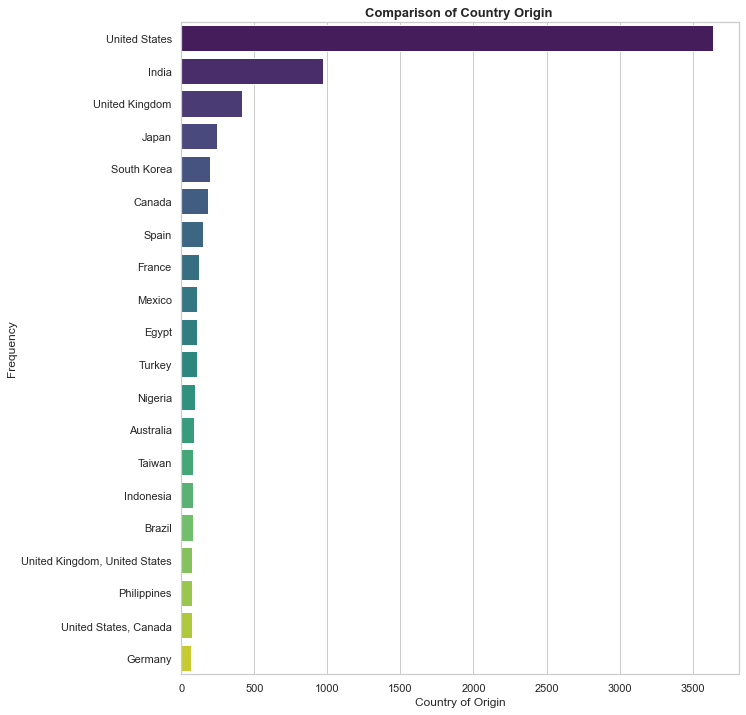

In [62]:
# Histogram - Frequency of Country of Origin - CONVERT TO TOP 20
plt.figure(figsize=(10,12))
sns.countplot(y="country", data=rslt_df, orient='h', palette="viridis", order=rslt_df['country'].value_counts().index[0:20])
plt.title ("Comparison of Country Origin ", fontsize=13, fontweight="bold")
plt.xlabel("Country of Origin", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

Observation: As expected, the US, UK and India (Bollywood) are the top 3 content producers. Countries with well-funded arts programs are also in the top 10 (Canada, France, Japan, South Korea) however I am surprised that Nigeria is not higher up in the list since they have Nollywood- but that just means Netflix is not releasing much of their content. Also surprising that Spanish-speaking countries are not better represented since there are a lot of Spanish-speaking consumers for streaming content.

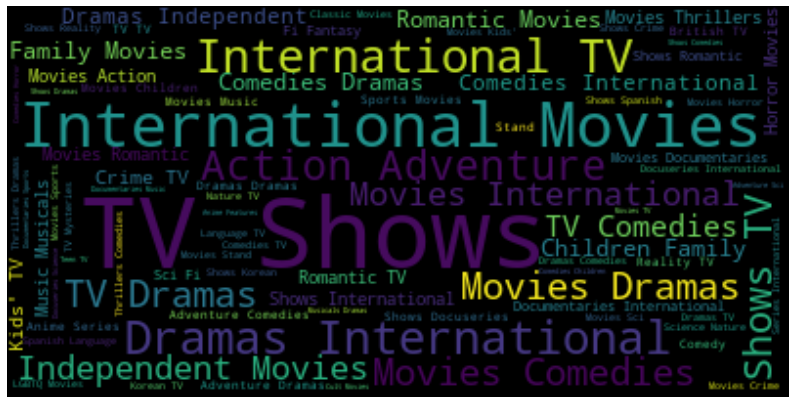

In [122]:
# WordCloud for genres
import itertools
from wordcloud import WordCloud

list_genre = df['listed_in'].tolist()
list_genre = list(itertools.chain(list_genre))
genre = ' '.join(list_genre)

plt.figure(figsize=(14,10))
wordcloud = WordCloud(max_font_size=50, max_words=100,background_color="black").generate(genre)
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()

### "Description" feature needs to be vectorized for search purposes

In [63]:
#remove stopwords
tfidf = TfidfVectorizer(stop_words='english')

#vectorize and transform description column
tfidf_matrix = tfidf.fit_transform(df['description'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(8790, 18878)

In [66]:
tfidf_matrix

<8790x18878 sparse matrix of type '<class 'numpy.float64'>'
	with 121142 stored elements in Compressed Sparse Row format>

## Model Version # 1 (NICK) - MODEL CREATION TRAINING & EVALUATION

#### Obtaining cosine similarity

In [6]:
#EDITED 5/24/22 NSH

tfidf_matrix[0:1]

from sklearn.metrics.pairwise import linear_kernel
cosine_similarities = linear_kernel(tfidf_matrix[0:1], tfidf_matrix).flatten()
most_similar = cosine_similarities.argsort()[:-5:-1]
cosine_similarities[most_similar]

array([1.        , 0.16093786, 0.14365733, 0.13671507])

#### KMeans Cluster Experimentation

8736.219312203473
8724.213373930164
8715.607570090327
8704.6687473971
8698.87092316292
8685.212282314165
8678.452863032024
8669.95683586844
8658.666472719846
8649.378251409747
8648.08658916238
8639.945750646846
8638.838456779984
8631.213277308774
8618.059500613297
8615.59768129941
8607.720108950334
8606.458471857366
8598.303642752056
8590.942683996871
8585.720783243894
8583.114364708154


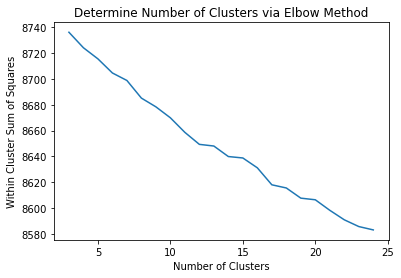

In [23]:
#EDITED 5/24/22 NSH

from sklearn.cluster import KMeans

features = tfidf.get_feature_names()
description_df = pd.DataFrame(tfidf_matrix.todense(), index=df[['title']], columns=features)
description_df

#Create list to analyze clustering strength of fit
wcss = []

#Search for the optimal number of clusters
for i in range(3, 25):
    kmeans = KMeans(n_clusters=i, random_state=45)
    kmeans.fit(description_df)
    wcss.append(kmeans.inertia_)
    print(kmeans.inertia_)

#Plot within cluster sum of squares against number of clusters
plt.plot(range(3,25), wcss)
plt.title("Determine Number of Clusters via Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Within Cluster Sum of Squares")
#plt.savefig("Cluster Assessment.png", bbox_inches='tight')
plt.show()

In [71]:
description_df #added 5.28.22 by KSC so dataframe would display

,000,007,009,10,100,1000,102,108,10th,11,...,zé,álex,álvaro,ángel,émile,ömer,über,łukasz,ōarai,şeref
"(Dick Johnson Is Dead,)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(Blood & Water,)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(Ganglands,)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(Jailbirds New Orleans,)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(Kota Factory,)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(Zodiac,)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(Zombie Dumb,)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(Zombieland,)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(Zoom,)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### KNN Model Creation function

In [80]:
#EDITED 5/24/22 NSH

from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors()
neighbors.fit(tfidf_matrix)


def get_recommendations(input_row, tfidf, number_recommendations=5):

    input_data = tfidf.transform(input_row.split())

    top_recommendations = neighbors.kneighbors(input_data, n_neighbors=number_recommendations)
    title_indices = top_recommendations[1][0]
    titles = [df.iloc[row]['title'] for row in title_indices]
    return(titles)


#### Testing the model

In [81]:
#EDITED 5/24/22 NSH

get_recommendations(input_row="This movie is about dragons, magic, monsters, and kings", tfidf=tfidf, number_recommendations=15)

['Pablo',
 'K.O. One Re-act',
 'Bangkok Love Stories: Innocence',
 'Donnie Brasco',
 'Hannibal',
 'KO One Return',
 'Drive',
 'Russell Peters vs. the World',
 'Sexo, Pudor y Lagrimas',
 'Bhangra Paa Le',
 'Bucket List',
 'W/O Ram',
 'Manglehorn',
 'Qurious Como',
 'Gbomo Gbomo Express']

### ML Flow Setup

In [82]:
#EDITED 5/24/22 NSH

from mlflow import log_metric, log_param, log_artifact
mlflow.log_param('n_neighbors', neighbors.n_neighbors)
mlflow.log_param('metric', neighbors.metric)
mlflow.sklearn.log_model(neighbors, "recommendation_model")
mlflow.sklearn.log_model(tfidf, "vectorizer")
mlflow.sklearn.save_model(neighbors, './Netflix_models/nearest_neighbors_model.pkl', serialization_format=mlflow.sklearn.SERIALIZATION_FORMAT_PICKLE)
mlflow.sklearn.save_model(tfidf, './Netflix_models/tfidf_vectorizer.pkl', serialization_format=mlflow.sklearn.SERIALIZATION_FORMAT_PICKLE)

2022/05/28 16:18:22 WARNING mlflow.tracking.context.git_context: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



## Model Version # 2 (SOMI) - MODEL CREATION TRAINING & EVALUATION

### Train the model

### Evaluate the model

## Model Version # 3 (KRISTY) 

In [83]:
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

indices = pd.Series(df.index, index=df['title']).drop_duplicates()

#### Recommendation engine function #1

In [107]:
def get_similar_titles(title, cosine_sim=cosine_sim):
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that title
    similar_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    similar_scores = sorted(similar_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar titles
    similar_scores = similar_scores[1:11]

    # Get the movie indices
    title_indices = [i[0] for i in similar_scores]

    # Return the top 10 most similar titles
    return df['title'].iloc[title_indices]

#### Evaluate the model

In [85]:
get_similar_titles('Midnight Mass')

7257    La Rosa de Guadalupe
1906                    Evil
3074                 Save Me
2971                Diablero
4268                Bird Box
7025              Hungerford
2026            Poshter Girl
8247    The Christmas Candle
2323          The Mirror Boy
3352         We Are the Wave
Name: title, dtype: object

Observation: Midnight Mass is a horror themed series with strong religious and supernatural overtones about a priest, a curse, vampires, and mysterious happenings on an isolated island. The first two results are accurate because they have to do with religious miracles (Guadalupe) or supernatural horror and religious themes (Evil). Save Me also deals with mysterious disappearances. The 4th recommended title, Diablero per IMDB is about "A fallen priest, a legendary demon hunter and a modern day superhero join forces to battle evil" -- which makes it an extremely accurate recommendation.

#### Recommendation Engine based on multiple input features

In [100]:
def lowercase_data(x):
        return str.lower(x.replace(" ", ""))

In [101]:
features=['title','director','cast','listed_in','description']
df_new=df[features]

In [102]:
for feature in features:
    df_new[feature] = df_new[feature].apply(lowercase_data)
    
df_new.head()

,title,director,cast,listed_in,description
0,dickjohnsonisdead,kirstenjohnson,unknown,documentaries,"asherfathernearstheendofhislife,filmmakerkirst..."
1,blood&water,unknown,"amaqamata,khosingema,gailmabalane,thabangmolab...","internationaltvshows,tvdramas,tvmysteries","aftercrossingpathsataparty,acapetownteensetsou..."
2,ganglands,julienleclercq,"samibouajila,tracygotoas,samueljouy,nabihaakka...","crimetvshows,internationaltvshows,tvaction&adv...","toprotecthisfamilyfromapowerfuldruglord,skille..."
3,jailbirdsneworleans,unknown,unknown,"docuseries,realitytv","feuds,flirtationsandtoilettalkgodownamongthein..."
4,kotafactory,unknown,"mayurmore,jitendrakumar,ranjanraj,alamkhan,ahs...","internationaltvshows,romantictvshows,tvcomedies",inacityofcoachingcentersknowntotrainindia’sfin...


In [103]:
def create_vectors(x):
    return x['title']+ ' ' + x['director'] + ' ' + x['cast'] + ' ' +x['listed_in']+' '+ x['description']

df_new['parsed'] = df_new.apply(create_vectors, axis=1)

In [104]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorized = CountVectorizer(stop_words='english')
count_matrix = vectorized.fit_transform(df_new['parsed'])

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [105]:
df_new=df_new.reset_index()
indices = pd.Series(df_new.index, index=df_new['title'])

In [106]:
df_new.head()

,index,title,director,cast,listed_in,description,parsed
0,0,dickjohnsonisdead,kirstenjohnson,unknown,documentaries,"asherfathernearstheendofhislife,filmmakerkirst...",dickjohnsonisdead kirstenjohnson unknown docum...
1,1,blood&water,unknown,"amaqamata,khosingema,gailmabalane,thabangmolab...","internationaltvshows,tvdramas,tvmysteries","aftercrossingpathsataparty,acapetownteensetsou...","blood&water unknown amaqamata,khosingema,gailm..."
2,2,ganglands,julienleclercq,"samibouajila,tracygotoas,samueljouy,nabihaakka...","crimetvshows,internationaltvshows,tvaction&adv...","toprotecthisfamilyfromapowerfuldruglord,skille...","ganglands julienleclercq samibouajila,tracygot..."
3,3,jailbirdsneworleans,unknown,unknown,"docuseries,realitytv","feuds,flirtationsandtoilettalkgodownamongthein...",jailbirdsneworleans unknown unknown docuseries...
4,4,kotafactory,unknown,"mayurmore,jitendrakumar,ranjanraj,alamkhan,ahs...","internationaltvshows,romantictvshows,tvcomedies",inacityofcoachingcentersknowntotrainindia’sfin...,"kotafactory unknown mayurmore,jitendrakumar,ra..."


#### Recommendation engine function #2

In [108]:
def get_similar_titles_v2(title, cosine_sim=cosine_sim):
    title=title.replace(' ','').lower()
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies/shows with that title
    similar_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    similar_scores = sorted(similar_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar titles
    similar_scores = similar_scores[1:11]

    # Get indices
    title_indices = [i[0] for i in similar_scores]

    # Return the top 10 most similar titles
    return df['title'].iloc[title_indices]

In [109]:
get_similar_titles_v2('Jaws', cosine_sim2)

42                                    Jaws 2
6077                               Abdo Mota
6429                         Casino Tycoon 2
169                                 Poseidon
8127                                Superfly
8231                                The Bund
44                         Jaws: The Revenge
2373                                 Saladin
7530                    Mutiny on the Bounty
7073    Indiana Jones and the Temple of Doom
Name: title, dtype: object

Observation: The list is fairly accurate because it includes two other sequels to the original and a few other big budget 80's films such as Indiana Jones. Unfortunately the second hit Abdo Mota is not that accurate as a foreign film with the description "After the mysterious death of his parents, a young man finds himself enmeshed in the dark world of drugs and crime."

In [111]:
get_similar_titles_v2('Training Day', cosine_sim2)

7851                  Reincarnated
6379             Brooklyn's Finest
8458    The Place Beyond the Pines
6793                      Fracture
8449             The Pelican Brief
895                         Oxygen
1903               An Ordinary Man
2668               Earth and Blood
5022                       반드시 잡는다
821              The Wedding Guest
Name: title, dtype: object

Observation: The first recommendation is not very accurate because it is a music documentary about Snoop Dog. However the second title Brooklyn's Finest is very accurate as it is also a crime drama about a pairing of cops featuring African American lead actors. The Place Behind the Pines is a crime thriller featuring a rookie cop so that is a good recommendation. Fracture, Oxygen and An Ordinary Man are also highly rated crime dramas and Pelican Brief is highly accurate as it is a legal drama with the same lead actor, Denzel Washington.

### MLFlow Setup

In [ ]:
# Set mlflow tracking URI to your local mlflow tracking server
mlflow.set_tracking_uri("http://localhost:5000")

In [ ]:
# This API will set the experiment name in MLFLow. 
mlflow.set_experiment("Netflix Recommendation Engine")

In [ ]:
# Check out the MLflow UI as this runs
mlflow.tensorflow.autolog(every_n_iter=10)

In [56]:
#Track Experimental Runs with MLFlow
def trackExperiments(run_name, compile_kwargs, fit_kwargs, optional_params={}):
  """
  This is a wrapper function for tracking experiments with MLflow
    
  Parameters
  ----------
  run_name: str
    Mlflow runname
    
  compile_kwargs: dict
    Keyword arguments to compile model with
  
  fit_kwargs: dict
    Keyword arguments to fit model with

  classes: dict
    Dict mapping class labels to class ID

  optional_params: dict
    Miscellaneous parameters to tune DNN, fed to build model function
  """
  with mlflow.start_run(run_name=run_name) as run:

    #Build model using the compile and optional parameters
    model = build_model(optional_params=optional_params, compile_kwargs=compile_kwargs)
    
    #fit model (Option 1)
    history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_val, y_val))
    
    #Fit model using fit keyword arguments (Option 2)
    history = model.fit(**fit_kwargs)
    
    #save model
    model.save("my_h5_model.h5")
    
    #Log parameters with MLFlow
    for param_key, param_value in {**fit_kwargs, **optional_params}.items():
      if param_key not in ["x", "y"]:
        mlflow.log_param(param_key, param_value)
    
    #Log performance with MLFlow
    for key, values in history.history.items():
      for i, v in enumerate(values):
        mlflow.log_metric(key, v, step=i)

    #Retain model architecture in MLFlow
    for i, layer in enumerate(model.layers):
      mlflow.log_param(f"hidden_layer_{i}_units", layer.output_shape)
    
    #Make predictions on test set
    predictions = model.predict(X_test)

    #Create dataframe to hold predictions and manipulate data
    predictions_df = pd.DataFrame()

    try:
    # Create metrics
      accuracypct = round(accuracy_score(analysis_df['Labels'], analysis_df['Predicted_Labels']) * 100, 2)
      F_1 = f1_score(analysis_df['Labels'], analysis_df['Predicted_Labels'], average='macro')

      # Log metrics to MLFLOW
      mlflow.log_metrics({"Test Accuracy": accuracypct, "F-1": F_1,})
    
    except:
      print("Metrics Error")

    try:
      #Create plot of loss functon
      pd.DataFrame(history.history).plot(figsize=(8,5))
      plt.grid(True)
      plt.gca().set_ylim(0,1)
      plt.title("Plotting Loss Function")
      plt.show()
    
    except:
      print("Plotting error")

    finally:
        plt.savefig("train-validation-loss.png")
        mlflow.log_artifact("train-validation-loss.png")

    try:
      #Create and save classification report as an artifact
      report = classification_report(analysis_df['Labels'], analysis_df['Predicted_Labels'], output_dict=True)
      reportdf = pd.DataFrame(report).T
      report_file = "Classification_Report" + datetime_str + ".csv"
      reportdf.to_csv(columns=reportdf.columns, path_or_buf="Classification_Report.csv")
      mlflow.log_artifact("Classification_Report.csv")

    except:
      print("Error occurred")

    #log model w/ MLFlow
    log_model(model, "Netflix_Recommendation_Engline_" + datetime_str)
    
    #Print accuracy with the test data
    print('Test Data accuracy: ', accuracy_score(y_test, predictions)*100)

    return run.info.run_uuid

In [57]:
# Specify arguments to compile the Keras classifier model - it would look like below
# classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
compile_kwargs = {
  "optimizer": tf.keras.optimizers.Adam(lr=.002, decay=.002/(2.5)), 
  "loss": "categorical_crossentropy",
  "metrics": ["accuracy"],
}

# Specify arguments to fit the Keras classifier model - it would look like below
# classifier.fit_generator(training_set, steps_per_epoch = 8000, epochs = 8, 
# validation_data = test_set, validation_steps = 2000, callbacks=clf_callbacks)
fit_kwargs = {
  "x": training_set, 
  #Steps per epoch should be total sample size / batch size
  "steps_per_epoch": 500,
  "epochs": 4,

  #Validate using validation set
  "validation_data": validation_set,
  "validation_steps": 500, 
  "callbacks": keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True),
  "verbose": 1
}

#Optional parameters
optional_params = {
  "activation": "relu",
  "batch_normalization": True,
  "padding": "valid",
  "dropout": True
}

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Add date & time stamp to current experiment run

In [ ]:
## Import Python datetime to create a runname that includes the datetime when it was started
from datetime import datetime

now = datetime.now() # current date and time
datetime_str = now.strftime("%m%d%Y_%H%M%S")
print(datetime_str)      

### Run first experiment

In [ ]:
compile_kwargs = {
  "optimizer": "RMSprop", 
  "loss": "categorical_crossentropy",
  "metrics": ["accuracy"],
}

# Specify arguments to fit the Keras classifier model - it would look like below
# classifier.fit_generator(training_set, steps_per_epoch = 8000, epochs = 8, 
# validation_data = test_set, validation_steps = 2000, callbacks=clf_callbacks)
fit_kwargs = {
  "x": training_set, 
  #Steps per epoch should be total sample size / batch size
  "steps_per_epoch": training_set.samples//32,
  "epochs": 4,

  #Validate using validation set
  "validation_data": validation_set,
  "validation_steps": validation_set.samples//32, 
  "callbacks": keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True),
  "verbose": 1
}

#Optional parameters
optional_params = {
  "activation": "relu",
  "batch_normalization": True,
  "padding": "valid",
  "dropout": True
}

In [ ]:
ml_run_name = "Netflix_Recommendation_Engline_" + datetime_str
print("ML run name: ", ml_run_name)

run_name = ml_run_name
run = trackExperiments(run_name, compile_kwargs, fit_kwargs, optional_params)

### Run 2nd experiment

In [ ]:
now = datetime.now() # current date and time
datetime_str = now.strftime("%m%d%Y_%H%M%S")

ml_run_name = "Netflix_Recommendation_Engline_" + datetime_str
print("ML run name: ", ml_run_name)

run_name = ml_run_name
run = trackExperiments(run_name, compile_kwargs, fit_kwargs, optional_params)

In [ ]:
history.history